In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notebook for catboost model development and testing

scores, frequency 15min: 
training on observed data only 
- 173 med objective="MultiRSME", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"
- 171 med objective="MAE", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"
- 180 med vanlig catboost, trent på time series data. 

training on both observed and estimated 


TRAINING ON HOURLY DATA 

159 - using normal catboost


168 - using catboost with objective="MAE", learning_rate=0.10931167365445349 colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"



## Getting data


## Training on combined observed and estimated data

In [105]:
%store -r dm 

from sklearn.model_selection import train_test_split

dm = dm

X_A_train = dm.data_A.iloc[:, 2:-1]
y_A_train = dm.data_A.iloc[:,0]
X_B_train = dm.data_B.iloc[:, 2:-1]
y_B_train = dm.data_B.iloc[:,0]
X_C_train = dm.data_C.iloc[:, 2:-1]
y_C_train = dm.data_C.iloc[:,0]


X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A_train, y_A_train, shuffle=False, train_size=0.9)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B_train, y_B_train, shuffle=False, train_size=0.9)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C_train, y_C_train, shuffle=False, train_size=0.9)

X_A_submission = dm.X_test_estimated_a[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]
X_B_submission = dm.X_test_estimated_b[dm.X_test_estimated_b.columns.intersection(X_B_train.columns)]
X_C_submission = dm.X_test_estimated_c[dm.X_test_estimated_c.columns.intersection(X_C_train.columns)]

print(X_train_A.shape, y_train_A.shape, X_test_A.shape, y_test_A.shape)
print(X_train_B.shape, y_train_B.shape, X_test_B.shape, y_test_B.shape)
print(X_train_C.shape, y_train_C.shape, X_test_C.shape, y_test_C.shape)



(30654, 44) (30654,) (3407, 44) (3407,)
(29537, 44) (29537,) (3282, 44) (3282,)
(23463, 44) (23463,) (2608, 44) (2608,)


## Using timeseries split to split our data 

In [89]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=15,
    max_train_size=7000,
    test_size=1000,
)

all_splits_A = list(ts_cv.split(X_train_A, y_train_A))
all_splits_B = list(ts_cv.split(X_train_B, y_train_B))
all_splits_C = list(ts_cv.split(X_train_C, y_train_C))



In [106]:
from catboost import CatBoostRegressor

catModel_A = CatBoostRegressor()
catModel_B = CatBoostRegressor()
catModel_C = CatBoostRegressor()

## training on the time series split 

In [91]:

from sklearn.metrics import mean_absolute_error
import pandas as pd

for train, test in (all_splits_A): 

    catModel_A.fit(X_train_A.iloc[train], y_train_A.iloc[train], silent=True, use_best_model=True, eval_set=(X_train_A.iloc[test], y_train_A.iloc[test]))

    preds_A = pd.DataFrame(catModel_A.predict(X_test_A))
    actual = y_test_A

    # preds_A = dm.scaling(preds_A, "A")
    # actual = dm.scaling(actual, "A") 

    print("CURRENT SCORING A ----->   ", mean_absolute_error(preds_A, actual))

for train, test in (all_splits_B): 

    catModel_B.fit(X_train_B.iloc[train], y_train_B.iloc[train], silent=True, use_best_model=True, eval_set=(X_train_B.iloc[test], y_train_B.iloc[test]))

    preds_B = pd.DataFrame(catModel_B.predict(X_test_B))
    actual = y_test_B

    # preds_B = dm.scaling(preds_B, "B")
    # actual = dm.scaling(actual, "B") 

    print("CURRENT SCORING B ----->   ", mean_absolute_error(preds_B, actual))

for train, test in (all_splits_C): 

    catModel_C.fit(X_train_C.iloc[train], y_train_C.iloc[train], silent=True, use_best_model=True, eval_set=(X_train_C.iloc[test], y_train_C.iloc[test]))

    preds_C = pd.DataFrame(catModel_C.predict(X_test_C))
    actual = y_test_C

    # preds_C = dm.scaling(preds_C, "C")
    # actual = dm.scaling(actual, "C") 

    print("CURRENT SCORING C ----->   ", mean_absolute_error(preds_C, actual))



CURRENT SCORING A ----->    140.55315803966158
CURRENT SCORING A ----->    151.35092125059577


KeyboardInterrupt: 

## training on the normally split data 

In [107]:

catModel_A.fit(X_train_A, y_train_A, silent=True)
catModel_B.fit(X_train_B, y_train_B, silent=True)
catModel_C.fit(X_train_C, y_train_C, silent=True)


In [109]:
import pandas as pd 
from sklearn.metrics import mean_absolute_error
preds_A = pd.DataFrame(catModel_A.predict(X_test_A))
actual = y_test_A

# preds_A = dm.scaling(preds_A, "A")
# actual = dm.scaling(actual, "A") 

print("CURRENT SCORING A ----->   ", mean_absolute_error(actual, preds_A))

preds_B = pd.DataFrame(catModel_B.predict(X_test_B))
actual = y_test_B

# preds_B = dm.scaling(preds_B, "B")
# actual = dm.scaling(actual, "B") 

print("CURRENT SCORING B ----->   ", mean_absolute_error(actual, preds_B))

preds_C = pd.DataFrame(catModel_C.predict(X_test_C))
actual = y_test_C

# preds_C = dm.scaling(preds_C, "C")
# actual = dm.scaling(actual, "C") 

print("CURRENT SCORING C ----->   ", mean_absolute_error(actual, preds_C))



CURRENT SCORING A ----->    129.56635921140077
CURRENT SCORING B ----->    25.18851023676961
CURRENT SCORING C ----->    22.820299362137316


In [111]:
## Specify the model to be used
pred_A = catModel_A.predict(X_A_submission)
pred_B = catModel_B.predict(X_B_submission)
pred_C = catModel_C.predict(X_C_submission)

## Uncomment if normalizing data
# pred_A = dm.scaling(pred_A, "A")
# pred_B = dm.scaling(pred_B, "B")
# pred_C = dm.scaling(pred_C, "C")

test = pd.read_csv('test.csv')

df_A = pd.DataFrame()

df_A["prediction"] = pred_A
df_A["location"] = "A"

df_B = pd.DataFrame()

df_B["prediction"] = pred_B
df_B["location"] = "B"

df_C = pd.DataFrame()

df_C["prediction"] = pred_C
df_C["location"] = "C"

df_mid = pd.concat([df_A, df_B], ignore_index=True)

df = pd.concat([df_mid, df_C], join="inner", ignore_index=True)

df = df.drop("location", axis=1)


# df["id"] = test["id"]

# df = df[["id", "prediction"]]

df[df<0] = 0

# NAME THE FILE 
df.to_csv("sub57.csv")

df

,prediction
0,0.121810
1,0.044046
2,0.000000
3,53.441650
4,196.493996
...,...
2155,38.850753
2156,30.505975
2157,0.949176
2158,0.004652


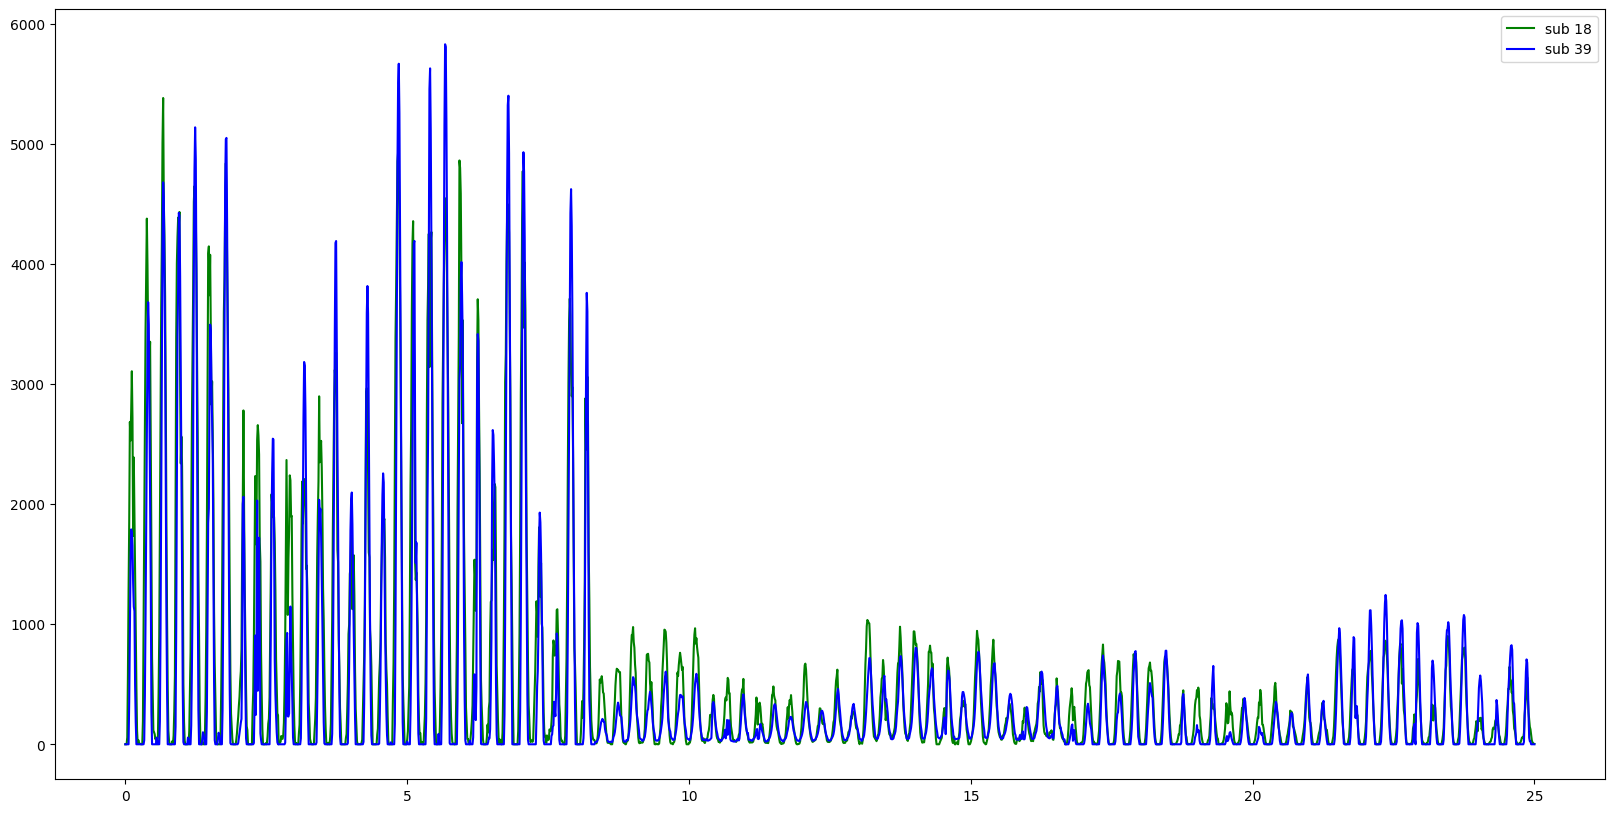

110.53349677672395


In [15]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
import pandas as pd

s18 = pd.read_csv("sub18.csv")
s39 = pd.read_csv("sub39.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub39.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 39") 

plt.legend() 
plt.show() 

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(s18, s39))



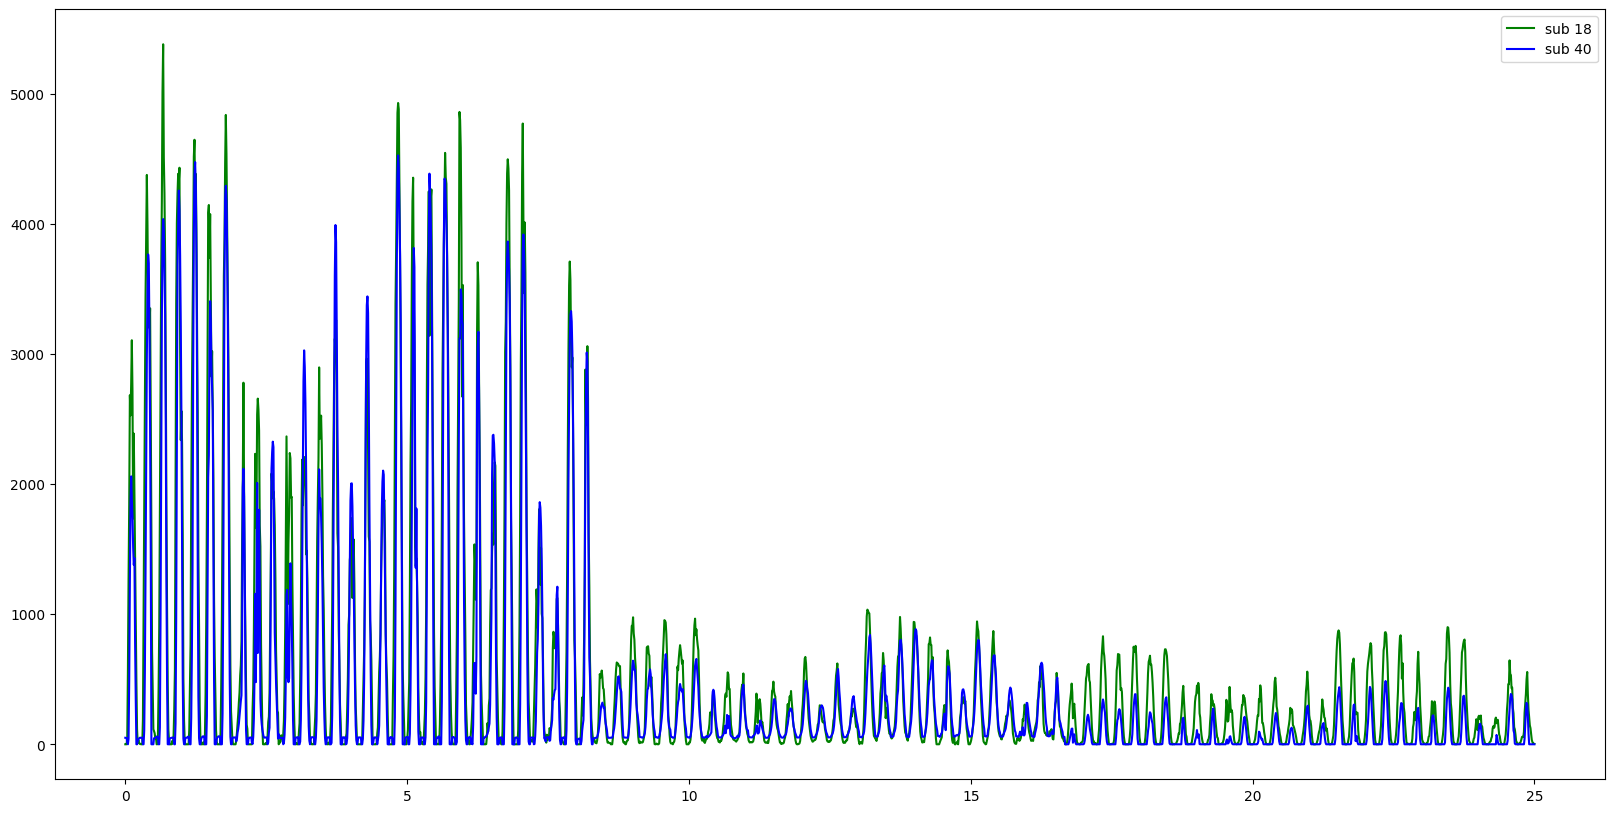

106.30018849256551


In [8]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 

s40 = pd.read_csv("sub40.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub40.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 40") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s40))

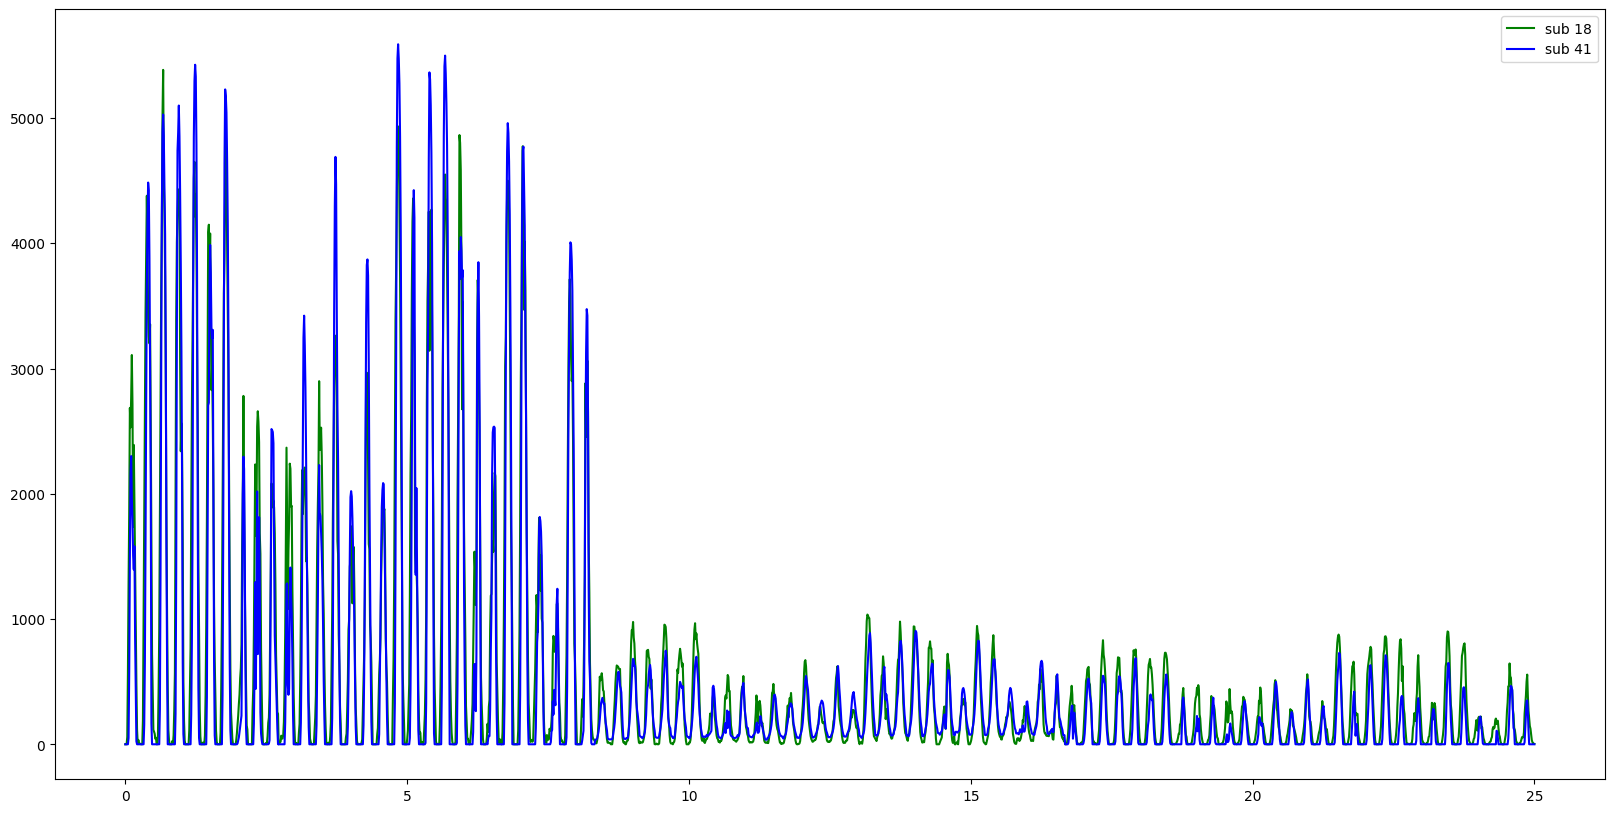

98.48684453609533


In [9]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 

s41 = pd.read_csv("sub41.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub41.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 41") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s41))

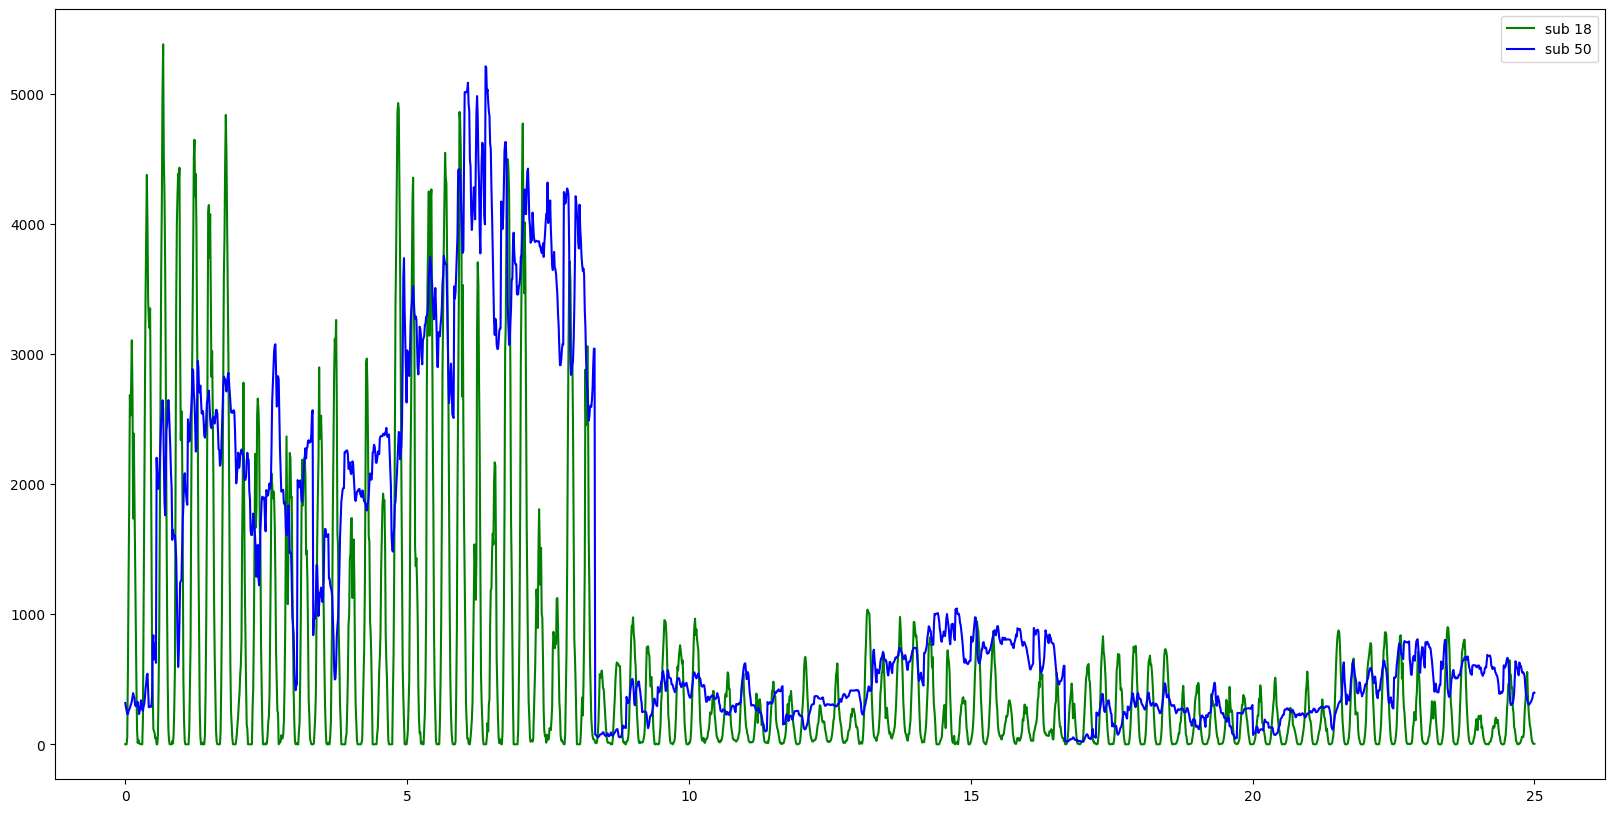

417.9924830685674


In [18]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 

s50 = pd.read_csv("sub50.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub50.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 50") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s50))

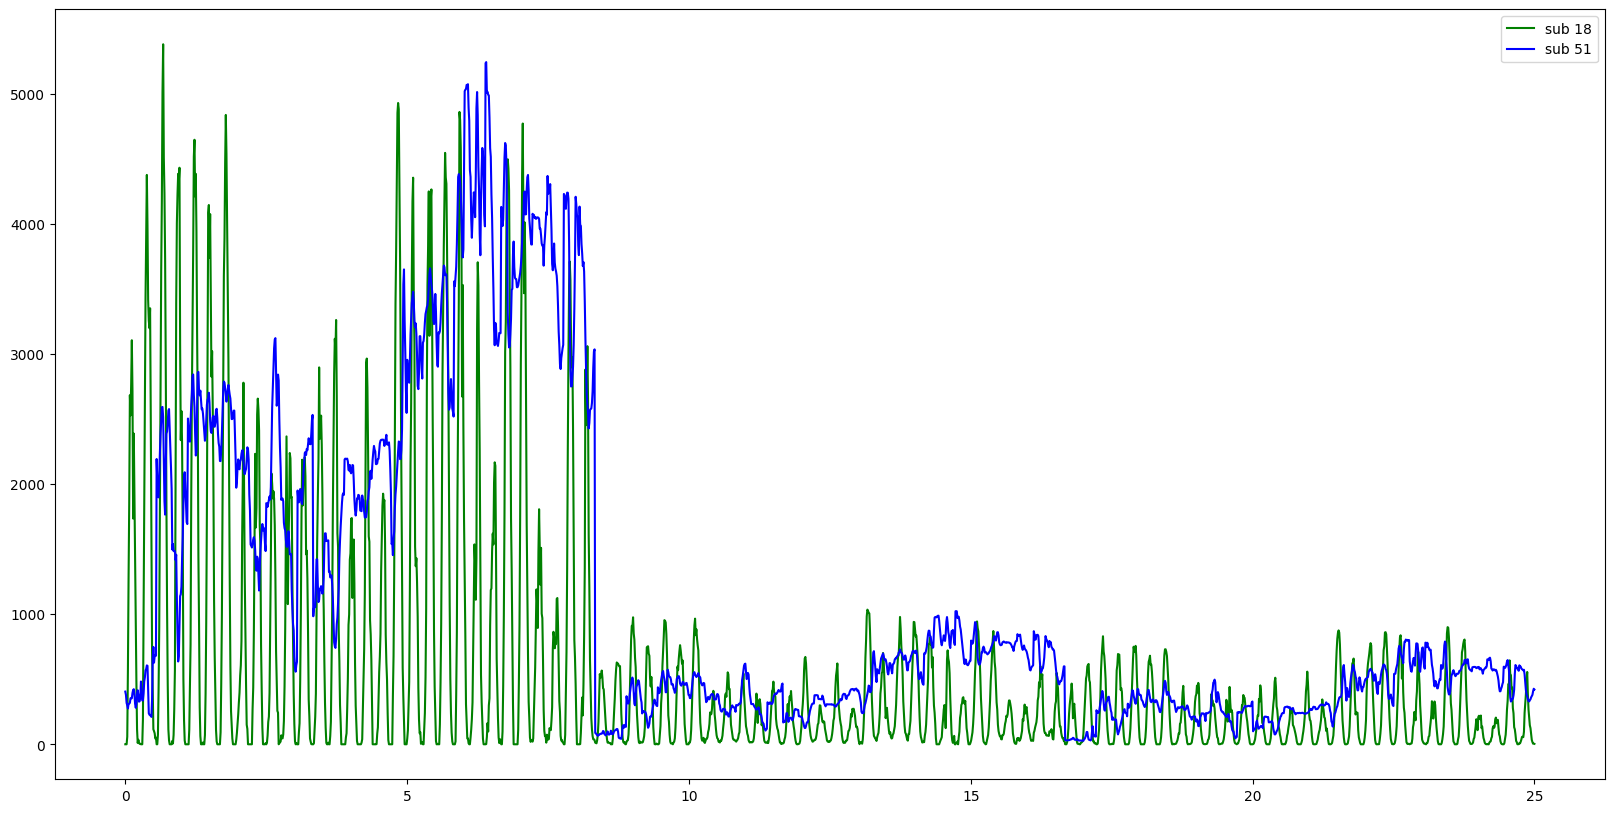

416.537155195012


In [25]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 

s51 = pd.read_csv("sub51.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub51.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 51") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s51))

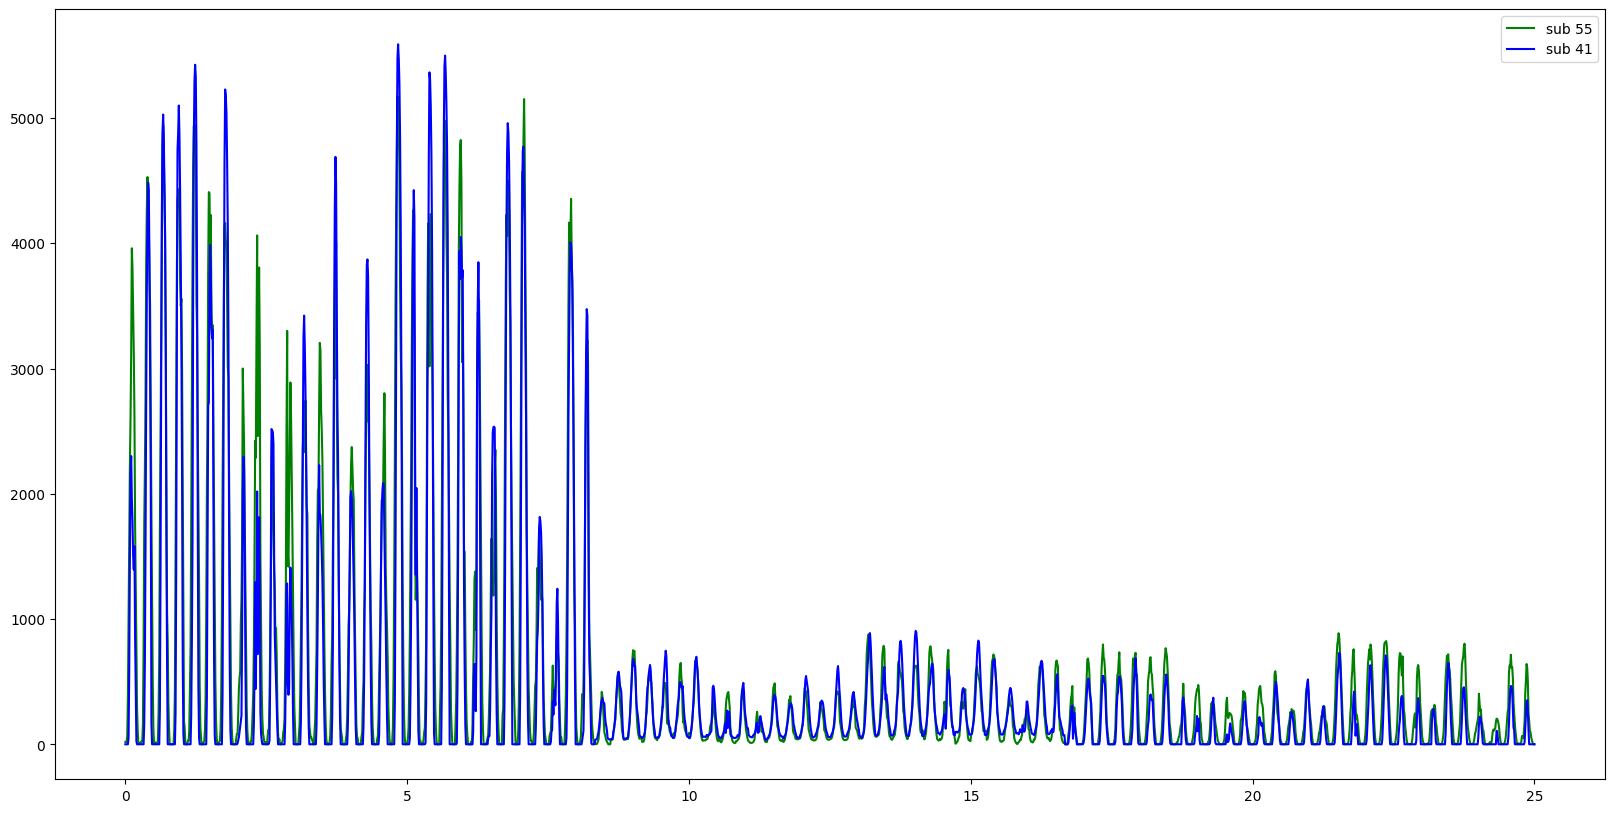

98.48684453609533


In [113]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
s55 = pd.read_csv("sub55.csv")
s52 = pd.read_csv("sub41.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub55.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 55") 

y2 = [] 
  
with open('sub41.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 41") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s52))